 # Time Series Analysis: Predicting Temparature

In [46]:
!aws s3 sync s3://.../mldata/ . --exclude '*' --include 'train.txt.gz'

In [50]:
def load_stream(stream):
    return pd.read_csv(stream, sep=' +', engine='python',
                         names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])

In [51]:
df = load_stream(gzip.open('train.txt.gz', 'rt'))

In [53]:
df.describe()

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour
count,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000,525869.000000
mean,2005.499349,6.523016,15.729663,11.499887,-76.307965,-142.707722,9672.123533,-224.544584,-169.008468,-129.403713,-17.965936,-9231.872328
std,3.452084,3.448686,8.800135,6.922240,1405.382671,1399.640272,3115.959808,2011.242691,1442.698025,1152.403884,436.947495,2663.638668
min,2000.000000,1.000000,1.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,2002.000000,4.000000,8.000000,5.000000,33.000000,-30.000000,10113.000000,70.000000,26.000000,2.000000,0.000000,-9999.000000
50%,2005.000000,7.000000,16.000000,11.000000,122.000000,61.000000,10163.000000,200.000000,41.000000,7.000000,0.000000,-9999.000000
75%,2008.000000,10.000000,23.000000,18.000000,206.000000,144.000000,10214.000000,280.000000,57.000000,8.000000,0.000000,-9999.000000
max,2011.000000,12.000000,31.000000,23.000000,406.000000,272.000000,10449.000000,360.000000,308.000000,9.000000,2558.000000,1760.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525869 entries, 0 to 525868
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   year        525869 non-null  int64 
 1   month       525869 non-null  int64 
 2   day         525869 non-null  int64 
 3   hour        525869 non-null  int64 
 4   temp        525869 non-null  int64 
 5   dew_temp    525869 non-null  int64 
 6   pressure    525869 non-null  int64 
 7   wind_angle  525869 non-null  int64 
 8   wind_speed  525869 non-null  int64 
 9   sky_code    525869 non-null  int64 
 10  rain_hour   525869 non-null  int64 
 11  rain_6hour  525869 non-null  int64 
 12  city        525869 non-null  object
dtypes: int64(12), object(1)
memory usage: 52.2+ MB


In [55]:
df = df[df.temp != -9999]

I will focus on using the temporal elements to predict the temperature.


### I build a "group-by" estimator that takes an estimator factory as an argument and builds the resulting "group-by" estimator on each city where each city will have it's own model. I'll then build a model to predict the temperature in a given city at a given time.

In [95]:
from sklearn import base


class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        self.column = column
        self.estimator_factory = estimator_factory
        # column is the value to group by; estimator_factory can be
        # called to produce estimators
    
    def fit(self, X, y):
        
        lst = []
        prt = []
        city_names = [i for i in X[self.column].unique()]

        for i in city_names:
            lst.append(X[X[self.column] == i])
            prt.append(np.array(X[X[self.column] == i]['temp']))
        
        self.bos_model = self.estimator_factory().fit(lst[0], prt[0])
        self.bal_model = self.estimator_factory().fit(lst[1], prt[1])
        self.chi_model = self.estimator_factory().fit(lst[2], prt[2])
        self.nyc_model = self.estimator_factory().fit(lst[3], prt[3])
        self.phi_model = self.estimator_factory().fit(lst[4], prt[4])
        
    
        return self
    
    def predict(self, X):
        
        bos_predict = self.bos_model.predict(X[X[self.column] == 'bos'])
        bal_predict = self.bal_model.predict(X[X[self.column] == 'bal'])
        chi_predict = self.chi_model.predict(X[X[self.column] == 'chi'])
        nyc_predict = self.nyc_model.predict(X[X[self.column] == 'nyc'])
        phi_predict = self.phi_model.predict(X[X[self.column] == 'phi'])
        
        return list(bos_predict) + list(bal_predict) + list(chi_predict) + list(nyc_predict) + list(phi_predict)

In [151]:
# Testing my functions

In [38]:
city_names = [i for i in df.city.unique()]
lst = []
prt = []
for i in city_names:
    lst.append(features.fit_transform(df[df['city'] == i][['month', 'hour']]))
    prt.append(np.array(df[df['city'] == i]['temp']))

In [25]:
lst[0].toarray()[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]])

In [41]:
prt

[array([-11,  -6, -17, ...,  39,  33,  33]),
 array([ 22,  11,   6, ..., 117, 111, 100]),
 array([ 0,  6, -6, ..., 28, 28, 28]),
 array([  6,   6,   6, ..., 111, 111,  94]),
 array([ 33,  28,  22, ..., 128, 117, 111])]

In [49]:
city_names

['bos', 'bal', 'chi', 'nyc', 'phi']

In [46]:
bos_model = Ridge().fit(lst[0], prt[0])

In [48]:
bos_model.predict(lst[0])

array([-33.23234309, -31.64579514, -30.05924719, ...,  33.00444246,
        34.59099041,  36.17753836])

In [50]:
city_names = [i for i in df.city.unique()]
lst = []
prt = []
for i in city_names:
    lst.append(df[df['city'] == i])
    prt.append(np.array(df[df['city'] == i]['temp']))

In [55]:
bos_model = season_factory().fit(lst[0], prt[0])

In [72]:
bal_model = season_factory().fit(lst[1], prt[1])

In [56]:
bos_model.predict(lst[0])

array([-33.23234309, -31.64579514, -30.05924719, ...,  33.00444246,
        34.59099041,  36.17753836])

In [75]:
bos_predict = bos_model.predict(df[df['city'] == 'bos'])


In [76]:
bos_predict

array([-33.23234309, -31.64579514, -30.05924719, ...,  33.00444246,
        34.59099041,  36.17753836])

In [87]:
bal_predict = bal_model.predict(df[df['city'] == 'bal'])


In [88]:
bal_predict

array([-21.17466857, -18.53653625, -15.89840393, ...,  53.73747345,
        56.37560578,  59.0137381 ])

In [ ]:
list(bos_predict) + list(bal_predict)

In [57]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder


In [52]:
def season_factory():
    features = ColumnTransformer([
    ('month', OneHotEncoder(), ['month']),
    ('numeric', 'passthrough', ['hour'])
    ])
    my_pipe = Pipeline([
    ('features', features),
    ('ridge_reg', Ridge())
    ])
    return my_pipe

# A single estimator or a pipeline


In [ ]:
season_factory()

In [96]:
season_model = GroupbyEstimator('city', season_factory).fit(df, df['temp'])

In [ ]:
season_model.predict(df)

### We know that temperature is roughly sinusoidal, and a reasonable model might be

##### $$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

### As we know from Fourier analysis, that the above is equivalent to

#### $$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

### which is linear in $A$ and $B$.

### I'll create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.

In [9]:
import scipy.fft
import matplotlib.pyplot as plt

In [10]:
fft = scipy.fft.fft((df.temp - df.temp.mean()).values)

(-1.0, 100.0)

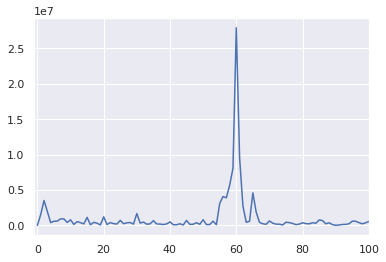

In [104]:
plt.plot(np.abs(fft))
plt.xlim([-1,100])

In [ ]:
# With Transformers

In [72]:
from sklearn.base import BaseEstimator
import pandas as pd
from sklearn.base import TransformerMixin

class ToFourierData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new = pd.to_datetime(X[['year', 'month', 'day', 'hour']]); new = pd.DataFrame(new)
        temp = X['temp']; temp = pd.DataFrame(temp)
        data = new.merge(temp, left_index=True, right_index=True)
        data = data.set_index(0)
        data['Julian'] = data.index.to_julian_date()
        data['sin(year)'] = np.sin(data['Julian'] / 365.25 * 2 * np.pi)
        data['cos(year)'] = np.cos(data['Julian'] / 365.25 * 2 * np.pi)
        data['sin(season)'] = np.sin(data['Julian'] / (365.25 / 4) * 2 * np.pi)
        data['cos(season)'] = np.cos(data['Julian'] / (365.25 / 4) * 2 * np.pi)
        data['sin(6mo)'] = np.sin(data['Julian'] / (365.25 / 2) * 2 * np.pi)
        data['cos(6mo)'] = np.cos(data['Julian'] / (365.25 / 2) * 2 * np.pi)
        data['sin(month)'] = np.sin(data['Julian'] / (365.25 / 12) * 2 * np.pi)
        data['cos(month)'] = np.cos(data['Julian'] / (365.25 / 12) * 2 * np.pi)
        data['sin(day)'] = np.sin(data.index.hour / 24.0 * 2* np.pi)
        data['cos(day)'] = np.cos(data.index.hour / 24.0 * 2* np.pi)
        data['sin(hour)'] = np.sin(data.index.hour / 24.0 * 2* np.pi)
        data['cos(day)'] = np.cos(data.index.hour / 24.0 * 2* np.pi)
        data = data[['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)',
                     'sin(month)', 'cos(month)', 'sin(day)', 'cos(day)',
                      'sin(season)', 'cos(season)']].reset_index()
        data = data.drop(0, axis=1)

        return data

In [73]:
ToFourierData().fit_transform(df)

,sin(year),cos(year),sin(6mo),cos(6mo),sin(month),cos(month),sin(day),cos(day),sin(season),cos(season)
0,-0.230151,0.973155,-0.447945,0.894061,-0.347403,-0.937716,0.000000,1.000000,-0.800980,0.598691
1,-0.229453,0.973320,-0.446663,0.894702,-0.355455,-0.934693,0.258819,0.965926,-0.799261,0.600985
2,-0.228756,0.973484,-0.445380,0.895342,-0.363482,-0.931601,0.500000,0.866025,-0.797534,0.603274
3,-0.228058,0.973648,-0.444096,0.895979,-0.371481,-0.928441,0.707107,0.707107,-0.795801,0.605558
4,-0.227360,0.973811,-0.442811,0.896615,-0.379453,-0.925211,0.866025,0.500000,-0.794062,0.607837
...,...,...,...,...,...,...,...,...,...,...
515576,-0.233637,0.972324,-0.454342,0.890827,-0.306767,-0.951785,-0.965926,0.258819,-0.809480,0.587147
515577,-0.232940,0.972491,-0.453064,0.891478,-0.314942,-0.949111,-0.866025,0.500000,-0.807793,0.589466
515578,-0.232243,0.972658,-0.451786,0.892126,-0.323093,-0.946367,-0.707107,0.707107,-0.806100,0.591779
515579,-0.231546,0.972824,-0.450506,0.892773,-0.331221,-0.943553,-0.500000,0.866025,-0.804400,0.594088


In [74]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


fourier_model = Pipeline([
    ('fourier_data', ToFourierData()),
    ('lr', LinearRegression())
])

In [76]:
final_model = fourier_model.fit(df, df['temp'] )

In [77]:
final_model.predict(df[:20])

array([ 20.36534407,  13.12737206,   5.33823122,  -2.47260516,
        -9.77418859, -16.0702787 , -20.93316129, -24.03279642,
       -25.15931013, -24.23729711, -21.3309595 , -16.63973168,
       -10.48468925,  -3.28666828,   4.46241386,  12.23308183,
        19.49438508,  25.75008122,  30.57245402,  33.63146155])

In [79]:
final_model.score(df, df['temp'])

0.7787018835999315

In [ ]:
# testing my functions

In [14]:
df

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city
0,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos
1,2000,1,1,1,-6,-78,10206,230,26,2,0,-9999,bos
2,2000,1,1,2,-17,-78,10211,230,36,0,0,-9999,bos
3,2000,1,1,3,-17,-78,10214,230,36,0,0,-9999,bos
4,2000,1,1,4,-17,-78,10216,230,36,0,0,-9999,bos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525864,2011,12,31,19,144,39,10105,280,46,-9999,0,-9999,phi
525865,2011,12,31,20,139,33,10113,310,67,8,0,-9999,phi
525866,2011,12,31,21,128,33,10125,300,82,8,0,-9999,phi
525867,2011,12,31,22,117,28,10138,300,46,4,0,-9999,phi


In [20]:
new = pd.to_datetime(df[['year', 'month', 'day', 'hour']])


In [21]:
new = pd.DataFrame(new)

In [22]:
temp = df['temp']

In [23]:
temp = pd.DataFrame(temp)

In [24]:
data = new.merge(temp, left_index=True, right_index=True)


In [25]:
data = data.set_index(0)
data['Julian'] = data.index.to_julian_date()


In [32]:
data['sin(year)'] = np.sin(data['Julian'] / 365.25 * 2 * np.pi)
data['cos(year)'] = np.cos(data['Julian'] / 365.25 * 2 * np.pi)
data['sin(season)'] = np.sin(data['Julian'] / (365.25 / 4) * 2 * np.pi)
data['cos(season)'] = np.cos(data['Julian'] / (365.25 / 4) * 2 * np.pi)
data['sin(6mo)'] = np.sin(data['Julian'] / (365.25 / 2) * 2 * np.pi)
data['cos(6mo)'] = np.cos(data['Julian'] / (365.25 / 2) * 2 * np.pi)
data['sin(month)'] = np.sin(data['Julian'] / (365.25 / 12) * 2 * np.pi)
data['cos(month)'] = np.cos(data['Julian'] / (365.25 / 12) * 2 * np.pi)
data['sin(day)'] = np.sin(data.index.hour / 24.0 * 2* np.pi)
data['cos(day)'] = np.cos(data.index.hour / 24.0 * 2* np.pi)
data['sin(hour)'] = np.sin(data.index.hour / 24.0 * 2* np.pi)
data['cos(day)'] = np.cos(data.index.hour / 24.0 * 2* np.pi)

In [63]:
data = data[['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(month)', 'cos(month)', 'sin(day)', 'cos(day)',
     'sin(season)', 'cos(season)']].reset_index()

In [64]:
data.drop(0, axis=1)

,sin(year),cos(year),sin(6mo),cos(6mo),sin(month),cos(month),sin(day),cos(day),sin(season),cos(season)
0,-0.230151,0.973155,-0.447945,0.894061,-0.347403,-0.937716,0.000000,1.000000,-0.800980,0.598691
1,-0.229453,0.973320,-0.446663,0.894702,-0.355455,-0.934693,0.258819,0.965926,-0.799261,0.600985
2,-0.228756,0.973484,-0.445380,0.895342,-0.363482,-0.931601,0.500000,0.866025,-0.797534,0.603274
3,-0.228058,0.973648,-0.444096,0.895979,-0.371481,-0.928441,0.707107,0.707107,-0.795801,0.605558
4,-0.227360,0.973811,-0.442811,0.896615,-0.379453,-0.925211,0.866025,0.500000,-0.794062,0.607837
...,...,...,...,...,...,...,...,...,...,...
515576,-0.233637,0.972324,-0.454342,0.890827,-0.306767,-0.951785,-0.965926,0.258819,-0.809480,0.587147
515577,-0.232940,0.972491,-0.453064,0.891478,-0.314942,-0.949111,-0.866025,0.500000,-0.807793,0.589466
515578,-0.232243,0.972658,-0.451786,0.892126,-0.323093,-0.946367,-0.707107,0.707107,-0.806100,0.591779
515579,-0.231546,0.972824,-0.450506,0.892773,-0.331221,-0.943553,-0.500000,0.866025,-0.804400,0.594088


In [137]:
len(a)

515581

In [80]:
fourier_model = final_model